[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/<USERNAME>/<REPO>/blob/<BRANCH>/<PATH/TO/NOTEBOOK.ipynb>)

# Executive Summary
This notebook trains a simple CNN with about 5 million parameters from scratch and finally reached an averaged accuracy of 90% and a weighted accuracy of 89% in the validation set. It demonstrat the potential viability to further develop an applicable model based on the dataset, indicating a strong patterns the CNN can learn from.

Further works may need be done to gain a better performance of classification:
- Try a more complex CNN model to get a better performance. In the meanwhile, increase the input size, which means less compression on original picture.
- Collect more data of bad performed class and fine tune on them to address the specific bad performance on several categories.
- Try transfer learning on current large CNN models with the dataset, which is possible to reach applicable performances.

# Download dataset from kaggle
The dataset is an extensive eye disease dataset containing original and augmented datasets of a variety of eye diseases including 10 categories: "Retinitis Pigmentosa, Retinal Detachment, Pterygium, Myopia, Macular Scar, Glaucoma, Disc Edema, Diabetic Retinopathy, Central Serous Chorioretinopathy, and Healthy eye image".

The original dataset of color fundus images for the detection and classification of eye diseases come from this paper: (https://www.sciencedirect.com/science/article/pii/S2352340924009417)

In [ ]:
! pip install kaggle
from google.colab import drive
drive.mount('/content/drive')
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/Kaggle_API/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download ruhulaminsharif/eye-disease-image-dataset
! unzip /content/eye-disease-image-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Original Dataset/Original Dataset/Diabetic Retinopathy/DR1209.jpg  
  inflating: Original Dataset/Original Dataset/Diabetic Retinopathy/DR121.jpg  
  inflating: Original Dataset/Original Dataset/Diabetic Retinopathy/DR1210.jpg  
  inflating: Original Dataset/Original Dataset/Diabetic Retinopathy/DR1211.jpg  
  inflating: Original Dataset/Original Dataset/Diabetic Retinopathy/DR1212.jpg  
  inflating: Original Dataset/Original Dataset/Diabetic Retinopathy/DR1213.jpg  
  inflating: Original Dataset/Original Dataset/Diabetic Retinopathy/DR1214.jpg  
  inflating: Original Dataset/Original Dataset/Diabetic Retinopathy/DR1215.jpg  
  inflating: Original Dataset/Original Dataset/Diabetic Retinopathy/DR1216.jpg  
  inflating: Original Dataset/Original Dataset/Diabetic Retinopathy/DR1217.jpg  
  inflating: Original Dataset/Original Dataset/Diabetic Retinopathy/DR1218.jpg  
  inflating: Original Dataset/Original Dataset/Diabetic Ret

# Model Training

## Data Preparation and Configurations

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import os
import math # Needed for calculating steps per epoch for checkpointing

# --- Configuration ---
# !!! IMPORTANT: Replace this with the actual path to your dataset !!!
DATASET_PATH = '/content/Augmented Dataset/Augmented Dataset' # e.g., './Eye_Disease_Dataset'
# Make sure DATASET_PATH contains subfolders like 'cataract', 'glaucoma', etc.

IMG_HEIGHT = 150  # Standard image height
IMG_WIDTH = 150   # Standard image width
BATCH_SIZE = 32   # Number of images processed in each batch
VAL_SPLIT = 0.2   # 20% of data used for validation/testing
CHECKPOINT_EPOCH_FREQ = 1 # Save model every 1 epochs
CHECKPOINT_DIR = './eye_disease_checkpoints' # Directory to save model checkpoints, this is in colab cache, will lose when deconnecting runtime
RANDOM_SEED = 123 # Seed for shuffling and splitting

# --- Check if Dataset Path Exists ---
if not os.path.isdir(DATASET_PATH):
    raise ValueError(f"Dataset directory not found at: {DATASET_PATH}\n"
                     "Please update the 'DATASET_PATH' variable with the correct location.")

In [ ]:
# --- 1. Create Full Dataset from Folders THEN Split ---
print("--- Loading Full Dataset ---")

# Load the entire dataset first, shuffling before splitting is important
full_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_PATH,
  seed=RANDOM_SEED, # Use seed for reproducible shuffle
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE, # Batching can happen here or after split
  label_mode='categorical', # Use 'categorical' for multi-class
  shuffle=True # Shuffle the full dataset before splitting
)

# Get class names and count
class_names = full_ds.class_names
num_classes = len(class_names)
print(f"Found {num_classes} classes: {class_names}")

# Determine the size of the dataset (number of batches)
# Use tf.data.experimental.cardinality to get the number of batches
dataset_size = tf.data.experimental.cardinality(full_ds).numpy()

if dataset_size <= 0 or dataset_size == tf.data.UNKNOWN_CARDINALITY or dataset_size == tf.data.INFINITE_CARDINALITY:
    # Fallback or Error - Calculating size needed for split
    # Simple fallback: Count files manually (less efficient for large datasets)
    try:
        print("Warning: Could not determine dataset size from tf.data.Dataset cardinality. Attempting file count...")
        image_count = len(full_ds.file_paths)
        dataset_size = math.ceil(image_count / BATCH_SIZE)
        print(f"Estimated dataset size based on file count: {dataset_size} batches ({image_count} files)")
        if dataset_size <= 0:
             raise ValueError("Dataset appears to be empty based on file count.")
    except Exception as e:
        raise ValueError(f"Could not determine dataset size automatically. Error: {e}. "
                         "Consider restructuring data loading or manually specifying dataset size.")


print(f"Total batches in the full dataset: {dataset_size}")

# Calculate the number of batches for training and validation sets
train_size = int((1.0 - VAL_SPLIT) * dataset_size)
val_size = dataset_size - train_size # Or use floor/ceil depending on preference

# Ensure sizes are valid
if train_size <= 0 or val_size <= 0:
    raise ValueError(f"Calculated split resulted in zero batches for training ({train_size}) or validation ({val_size}). "
                     f"Check dataset size ({dataset_size} batches) and VAL_SPLIT ({VAL_SPLIT}). Minimum 2 batches required for split.")

print(f"Splitting into {train_size} training batches and {val_size} validation batches.")

# Explicitly split the dataset
train_ds = full_ds.take(train_size)
val_ds = full_ds.skip(train_size) # Skip the batches taken for training

# --- Performance Optimization (Applied AFTER splitting) ---
AUTOTUNE = tf.data.AUTOTUNE
# Add shuffle specifically for training batches per epoch, cache, and prefetch
train_ds = train_ds.cache().shuffle(buffer_size=1000).prefetch(buffer_size=AUTOTUNE)
# Just cache and prefetch validation data (no shuffling needed)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("--- Datasets Prepared and Split ---")

--- Loading Full Dataset ---
Found 16242 files belonging to 10 classes.
Found 10 classes: ['Central Serous Chorioretinopathy-Color Fundus', 'Diabetic Retinopathy', 'Disc Edema', 'Glaucoma', 'Healthy', 'Macular Scar', 'Myopia', 'Pterygium', 'Retinal Detachment', 'Retinitis Pigmentosa']
Total batches in the full dataset: 508
Splitting into 406 training batches and 102 validation batches.
--- Datasets Prepared and Split ---


## Model Constructing and Compiling

In [ ]:
# --- 2. Create an Effective CNN Model ---
# (This part remains the same as the previous correct answer)
print("--- Building CNN Model ---")
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation='softmax')
])
print("--- Model Built ---")
model.summary()

# --- 3. Compile Model and Train ---
print("--- Compiling Model ---")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
print("--- Model Compiled ---")

--- Building CNN Model ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


--- Model Built ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,403,082 (20.61 MB)

 Trainable params: 5,403,082 (20.61 MB)

 Non-trainable params: 0 (0.00 B)

--- Compiling Model ---
--- Model Compiled ---


## First training

In [ ]:
# --- Setup Model Checkpointing ---
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Use the calculated 'train_size' (number of training batches) for steps_per_epoch
steps_per_epoch = train_size # This IS the number of batches in train_ds
save_freq_steps = steps_per_epoch * CHECKPOINT_EPOCH_FREQ
print(f"Actual training batches per epoch: {steps_per_epoch}")
print(f"Model Checkpoints will be saved every {save_freq_steps} steps (approx. {CHECKPOINT_EPOCH_FREQ} epochs).")

checkpoint_filepath = os.path.join(CHECKPOINT_DIR, 'epoch_{epoch:02d}.weights.h5')
cp_callback_weights = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True, # Only save weights
    save_freq='epoch',      # Save every epoch ('epoch' or integer steps)
    verbose=1)
# Callback to save the *best* model based on validation loss (weights only)
best_checkpoint_path = os.path.join(CHECKPOINT_DIR, "best_ckpt.weights.h5")
cp_callback_best = tf.keras.callbacks.ModelCheckpoint(
    filepath=best_checkpoint_path,
    save_weights_only=True,
    monitor='val_loss',     # Monitor validation loss
    mode='min',             # Save when 'val_loss' is minimum
    save_best_only=True,    # Only save if it's the best so far
    verbose=1)

print("--- Starting Training ---")
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=300,
  callbacks=[[cp_callback_weights, cp_callback_best]]
)
print("--- Training Finished ---")

# Save the final model
final_model_path = os.path.join(CHECKPOINT_DIR, 'final_model_eye_disease.keras')
model.save(final_model_path)
print(f"Final model saved to: {final_model_path}")

Actual training batches per epoch: 406
Model Checkpoints will be saved every 406 steps (approx. 1 epochs).
--- Starting Training ---
Epoch 1/300
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2671 - loss: 2.0084
Epoch 1: saving model to ./eye_disease_checkpoints/epoch_01.weights.h5

Epoch 1: val_loss improved from inf to 1.63339, saving model to ./eye_disease_checkpoints/best_ckpt.weights.h5
406/406 ━━━━━━━━━━━━━━━━━━━━ 49s 64ms/step - accuracy: 0.2672 - loss: 2.0082 - val_accuracy: 0.3929 - val_loss: 1.6334
Epoch 2/300
403/406 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3830 - loss: 1.7131
Epoch 2: saving model to ./eye_disease_checkpoints/epoch_02.weights.h5

Epoch 2: val_loss improved from 1.63339 to 1.53769, saving model to ./eye_disease_checkpoints/best_ckpt.weights.h5
406/406 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.3831 - loss: 1.7128 - val_accuracy: 0.4388 - val_loss: 1.5377
Epoch 3/300
400/406 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4325 - loss: 1.5696

--- Plotting Training History ---


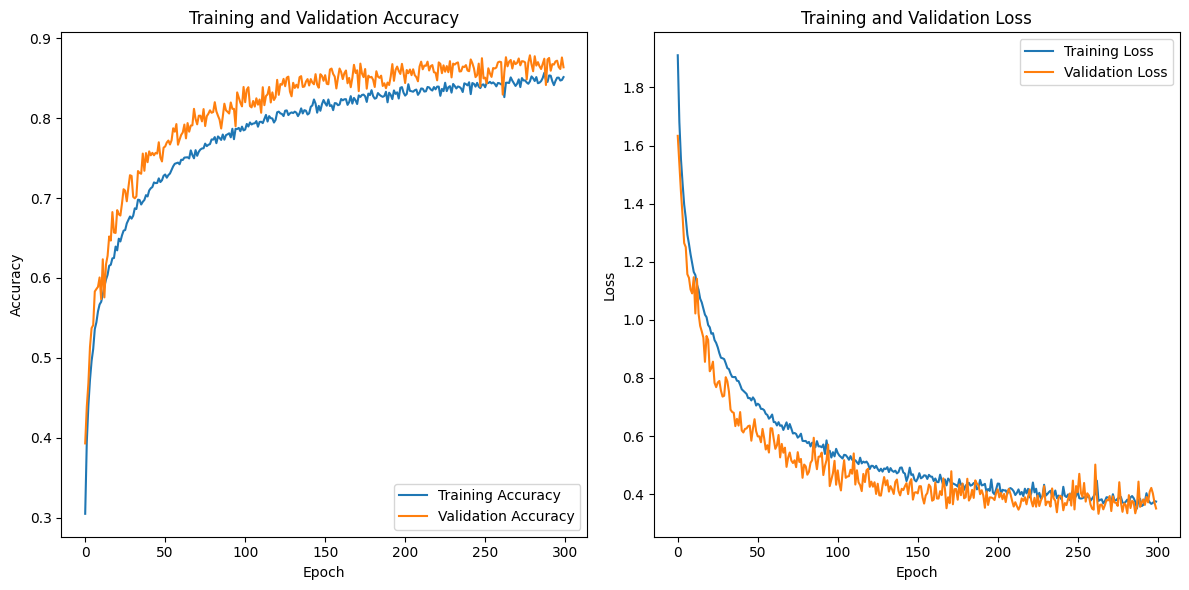

--- Plotting Complete ---


In [ ]:
# --- 4. Draw the Epoch-Accuracy Graph ---
# (This part remains the same as the previous correct answer)
print("--- Plotting Training History ---")
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(300)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()
print("--- Plotting Complete ---")

## Fine Tune
From the first training, the accuracy continue increase and training loss continue decrease and they reached a plateau in the end. It is resonable to start fine tune the current optimal model with a lower learning rate. We will try 0.0001 learning rate and 200 iterations to see what's going on.

In [ ]:
# Check the weights
print(model.weights[0][0,:5])
print("--- Recompiling Model ---")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
print("--- Model recompiled ---")
print(model.weights[0][0,:5]) # Optional: Verify weights haven't changed during recompile

tf.Tensor(
[[[-3.39756042e-01  9.46085602e-02  1.38046788e-02  6.21416681e-02
    3.86997336e-03 -6.50886744e-02 -4.44706008e-02 -4.61921766e-02
    3.75340618e-02 -7.63515308e-02  1.46536216e-01  7.30440617e-02
   -4.38561030e-02  1.08876243e-01 -2.89514571e-01  1.09366991e-01
    6.92224950e-02  1.05517715e-01 -1.28711179e-01 -2.35453203e-01
    9.78868827e-02 -2.06643984e-01 -1.49074808e-01  6.00103289e-02
    2.23002195e-01 -2.40388095e-01 -1.42641276e-01 -5.79330742e-01
   -2.11983416e-02 -1.78807661e-01  5.84809594e-02 -4.20831382e-01]
  [-3.94528747e-01 -1.81804031e-01 -3.03212911e-01 -7.59357512e-02
    2.74191778e-02  2.40072191e-01 -2.19591670e-02 -1.14060268e-01
   -5.59665747e-02 -2.18957528e-01 -4.14675534e-01 -1.60278887e-01
    1.56511232e-01 -6.15650862e-02 -1.42449453e-01 -1.91968888e-01
    1.37690142e-01 -6.12841733e-02  2.57380456e-01  1.61454737e-01
    1.20508228e-03 -2.96507746e-01 -3.02792251e-01 -3.35021242e-02
    6.86120391e-02 -1.53228953e-01 -2.23947674e-01

In [ ]:
print("Resuming training...")
# Use the same parameters (or adjust as needed) for continuing training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=200,
    callbacks=[[cp_callback_weights, cp_callback_best]]
)
print("Training resumed and completed.")

# Optional: Save the model again after further training
# loaded_model.save('your_further_trained_model.h5')
# print("Model saved after further training.")
# Save the final model
final_model_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/Eye_Disease_Image_Classification/', 'final_model_eye_disease_afterfinetune.keras')
model.save(final_model_path)
print(f"Final model saved to: {final_model_path}")

Resuming training...
Epoch 1/200
405/406 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8609 - loss: 0.3251
Epoch 1: saving model to ./eye_disease_checkpoints/epoch_01.weights.h5

Epoch 1: val_loss did not improve from 0.33230
406/406 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8609 - loss: 0.3250 - val_accuracy: 0.8791 - val_loss: 0.3399
Epoch 2/200
406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8764 - loss: 0.2906
Epoch 2: saving model to ./eye_disease_checkpoints/epoch_02.weights.h5

Epoch 2: val_loss improved from 0.33230 to 0.33210, saving model to ./eye_disease_checkpoints/best_ckpt.weights.h5
406/406 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8764 - loss: 0.2906 - val_accuracy: 0.8822 - val_loss: 0.3321
Epoch 3/200
400/406 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8815 - loss: 0.2776
Epoch 3: saving model to ./eye_disease_checkpoints/epoch_03.weights.h5

Epoch 3: val_loss improved from 0.33210 to 0.32758, saving model to ./eye_disease_checkpoints/best_ckpt.

--- Plotting Training History ---


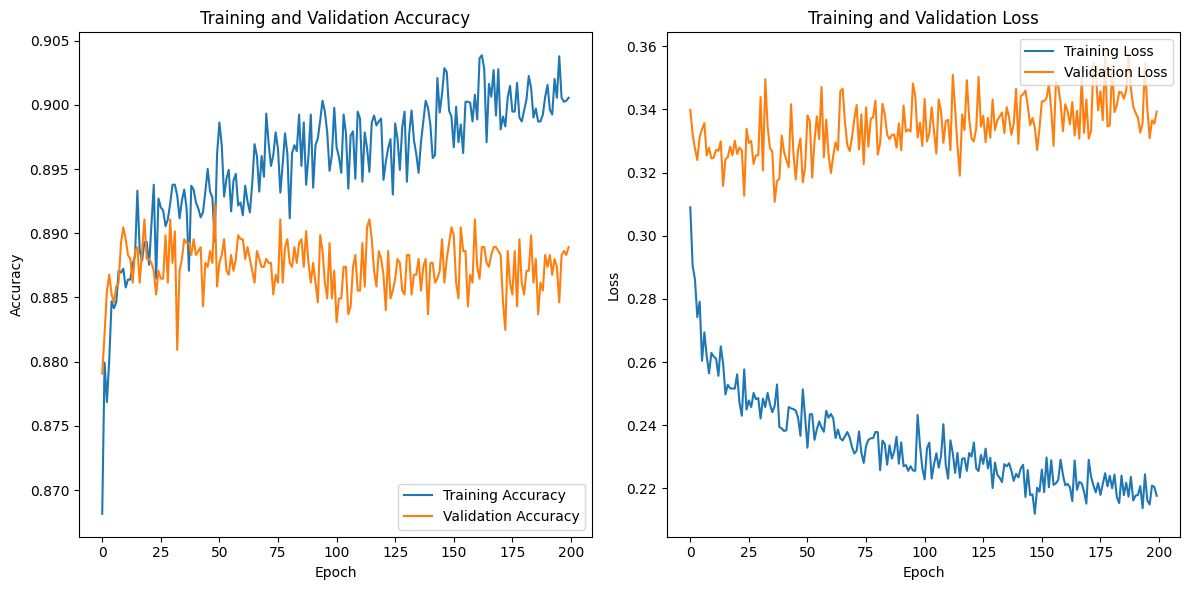

--- Plotting Complete ---


In [ ]:
# (This part remains the same as the previous correct answer)
print("--- Plotting Training History ---")
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(200)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()
print("--- Plotting Complete ---")

According to the accuracy/loss-epoch plots, the model start being over-fitting over the trainig iterations. We pick the best model which seems to be the critical point where the model start being overfitting. Finally, the best model have 89.56% accuracy and 0.2425 loss in train set, and 88.92% accuracy and 0.3108 loss in test set.

The original picture size is 2004 \* 1690, so it loss considerable information after being compressed to 150 \* 150. Therefore, it is a reasonaable attempt to rescale the images into a larger size (like 224 * 224) and increase the complexity of model in the meanwhile, which will expect a better performance.

Besides, the intrinsic bias of the dataset must be carefully considered as there may be less percentages to increase. Another problem is the dataset with about 5000 pictures is small for training a powerful and more accurate CNN models. If we want to train a more complex model, it is probably to be overfitting. After we apply regulizations and dropouts, it may reach the same performance as the simpler model which consumes less computing resouces and time.

# Model Evaluation
This section will evaluate our optimal model in more detail like confusion matrix and separate catagory prediction, then discuss the potential solution to improve it.

TensorFlow Version: 2.18.0
Num GPUs Available: 0
Loading model from: /content/drive/MyDrive/Colab Notebooks/Eye_Disease_Image_Classification/final_model_eye_disease_afterfinetune.keras


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,209,248 (61.83 MB)

 Trainable params: 5,403,082 (20.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,806,166 (41.22 MB)

Performing predictions on the test dataset...
Predictions finished. Found 3250 samples.
Shape of y_true: (3250,)
Shape of y_pred: (3250,)

Generating Confusion Matrix...


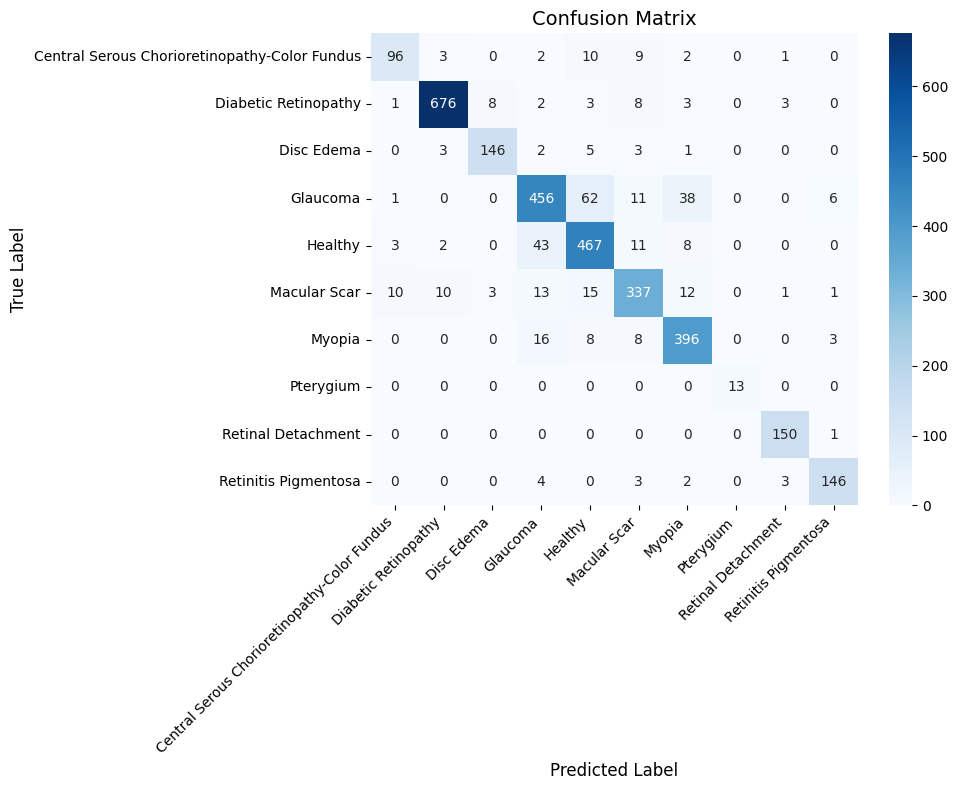


Generating Classification Report...

Classification Report:

                                               precision    recall  f1-score   support

Central Serous Chorioretinopathy-Color Fundus       0.86      0.78      0.82       123
                         Diabetic Retinopathy       0.97      0.96      0.97       704
                                   Disc Edema       0.93      0.91      0.92       160
                                     Glaucoma       0.85      0.79      0.82       574
                                      Healthy       0.82      0.87      0.85       534
                                 Macular Scar       0.86      0.84      0.85       402
                                       Myopia       0.86      0.92      0.89       431
                                    Pterygium       1.00      1.00      1.00        13
                           Retinal Detachment       0.95      0.99      0.97       151
                         Retinitis Pigmentosa       0.93      0.92 

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os # Optional: for path joining

print(f"TensorFlow Version: {tf.__version__}")
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

# --- 1. Configuration ---
MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/Eye_Disease_Image_Classification/final_model_eye_disease_afterfinetune.keras' # <<<--- CHANGE THIS to your model's path

test_dataset = val_ds # The dataset to predict


# Class name in correct order
CLASS_NAMES = ['Central Serous Chorioretinopathy-Color Fundus', 'Diabetic Retinopathy', 'Disc Edema', 'Glaucoma', 'Healthy', 'Macular Scar', 'Myopia', 'Pterygium', 'Retinal Detachment', 'Retinitis Pigmentosa'] # e.g., ['Cat', 'Dog', 'Bird']

# --- Check if model file exists ---
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model file not found at: {MODEL_PATH}")


# --- 2. Load the Saved Keras Model ---
print(f"Loading model from: {MODEL_PATH}")
try:
    model = tf.keras.models.load_model(MODEL_PATH)
    model.summary() # Print model summary to verify
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

# --- 3. Perform Prediction on the Test Dataset ---
print("Performing predictions on the test dataset...")
y_pred_list = []
y_true_list = []

# Iterate over the dataset to get predictions and true labels
for features_batch, labels_batch in test_dataset:
    # Get model predictions (probabilities)
    predictions_batch = model.predict(features_batch, verbose=0)
    # Convert probabilities to predicted class index
    predicted_classes = np.argmax(predictions_batch, axis=1)
    y_pred_list.extend(predicted_classes)

    # Convert labels batch to numpy array
    labels_batch_np = labels_batch.numpy()

    # Check if labels are one-hot encoded or integer indices
    if len(labels_batch_np.shape) > 1 and labels_batch_np.shape[1] > 1:
        # Labels are one-hot encoded, convert to integer indices
        true_classes = np.argmax(labels_batch_np, axis=1)
    else:
        # Labels are already integer indices
        true_classes = labels_batch_np

    y_true_list.extend(true_classes)

# Convert lists to numpy arrays
y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)

print(f"Predictions finished. Found {len(y_true)} samples.")

# Verify shapes
print(f"Shape of y_true: {y_true.shape}")
print(f"Shape of y_pred: {y_pred.shape}")

# Ensure CLASS_NAMES length matches the number of classes found/predicted
if num_classes != len(CLASS_NAMES):
     print(f"Warning: Number of classes derived from data ({num_classes}) might not match length of CLASS_NAMES ({len(CLASS_NAMES)}). Confusion matrix/report labels might be incorrect.")


# --- 4. Generate and Draw the Confusion Matrix ---
print("\nGenerating Confusion Matrix...")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

# --- 5. Generate Classification Report ---
print("\nGenerating Classification Report...")
try:
    report = classification_report(y_true, y_pred, target_names=CLASS_NAMES)
    print("\nClassification Report:\n")
    print(report)
except ValueError as e:
     print(f"\nError generating classification report: {e}")
     print("This might happen if some classes in CLASS_NAMES are not present in y_true or y_pred.")
     # Optional: Generate report without target names if there's a mismatch
     # report = classification_report(y_true, y_pred)
     # print("\nClassification Report (without names):\n")
     # print(report)

print("\nEvaluation script finished.")

According to the classification report above, the model have different performances depending on category. It is noted that the disease "Pterygium" has much less instances (13 in toal) to predict so the accuracy is not trustable, which can be further checked by collecting more data.

The model perform well in "Diabetic Retinopathy,  Disc Edema, Retinal Detachment, Retinitis Pigmentosa", with a f1-score above 0.92. In comparasion, the model perform not so good on other categories including "Central Serous Chorioretinopathy-Color Fundus, Glaucoma, Healthy, Macular Scar and Myopia", with f1-score below 0.90. It is worth to fine tune the model on the bad performed class and try to improve its accuracy on them in the future works.

# Conclusion

In summary, this notebook try to train a simple CNN with about 5 million parameters from scratch and finally reached an averaged accuracy of 90% and a weighted accuracy of 89% in total.

Further works may need be done to gain a better performance of classification:
- Try a more complex CNN model to get a better performance. In the meanwhile, increase the input size, which means less compression on original picture.
- Collect more data of bad performed class and fine tune on them to address the specific bad performance on several categories.
- Try transfer learning on current large CNN models with the dataset, which is possible to reach applicable performances.